In [23]:
import os

In [24]:
os.getcwd()

'/home/marc/Git/HARK/ConsumptionSaving'

In [25]:
#change the line below to your local HARK file location
os.chdir('/home/marc/Git/HARK')

In [26]:
os.getcwd()

'/home/marc/Git/HARK'

In [27]:
ls

cAndCwithStickyE/   HARKestimation.py      HARKutilities.pyc
ConsumptionSaving/  HARKinterpolation.py   __index__.py
cstwMPC/            HARKinterpolation.pyc  LICENSE
Documentation/      HARKparallel.py        README.md
FashionVictim/      HARKsimulation.py      SolvingMicroDSOPs/
HARKcore.py         HARKsimulation.pyc     Testing/
HARKcore.pyc        HARKutilities.py


# Implementation of a Tractable Model Of Buffer Stock Saving 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This notebook implements the Carroll et. al.'s Tractable Model of Buffer Stock Saving (2009) using HARK.  The notebook is intended as a guide to using HARK, and provides only a basic outline of the model.  For a full theoretical explanation, see the [Lecture Notes for the Tractable Model](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock.pdf).  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this notebook, we solve the consumer's consumption vs. saving optimization problem
using HARK's simulation method. We compare the solution obtained via simulation to the solution obtained via traditional analytical methods, demonstrating the efficiency and applicability of HARK's simulation method.
<br/><br/>
The consumer's problem is optimizing utility derived from consumption for the current period $t$ until end of life $T$,
<br/>
$max \: E_{t} \Big[ \sum_{n=0}^{T-t} \beta^n u(\textbf{c}_{t+n})\Big]   $
<br/><br/>
The solution is characterized by the below elements, making up the consumer's Dynamic Budget Constraint,<br/>
$\textbf{a}_{t} = \textbf{m}_{t} - \textbf{c}_{t}$<br/>
$\textbf{b}_{t+1} = R\textbf{a}_{t}$<br/>
$\textbf{m}_{t+1} = \textbf{b}_{t+1}+\ell_{t+1}W_{t+1}\xi_{t+1}$
<br/>
where $\textbf{a}$ is end-of-period assets (after the period's consumption decision); $\textbf{m}$ is market resources (net worth plus current income); $\textbf{c}$ is consumption; $\textbf{b}$ is bank balance before receipt of labor income;$\textbf{R}$ is constant interest factor; $\ell$ measures the consumer's labor productivity ('endowment'); $W$ is the aggregate wage rate; and $\xi$ is a dummy variable indicating consumer's employment state ('e' employed or 'u' unemployed.
<br/><br/>
The goal is to find the optimal consumption, $c_{t}$, for a given amount of market resources, $m_{t}$. This is accomplished via the consumption Euler equation,<br/>
$\frac{c_{t+1}^e}{c_{t}^e}=P_{\Gamma}\Bigg\{1 + \Upsilon\bigg[\bigg(\frac{c_{t+1}^e}{c_{t+1}^u}\bigg)^\rho-1\bigg]\Bigg\}^{1/\rho}$
<br/>
<br/>
where $\Upsilon$ is the probability a consumer becomes unemployed,<br/>
$P_{\Gamma}$ is the 'growth patience factor',<br/>
&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;$P_{\Gamma}=\bigg(\frac{(R\beta)^{1/\rho}}{\Gamma}\bigg)$ &nbsp; &nbsp; with $\Gamma=G/(1-\Upsilon)$, &nbsp; $G$ is the labor income growth factor, &nbsp; $1-\Upsilon$ is the probability a consumer remains employed, &nbsp;
<br/>&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp; $\beta$ is the discount factor, and $\rho$ is the consumer's prudence factor (a more in-depth discussion of the mathematical relationship between factors can be found in [the lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock.pdf)).  
<br/>
HARK solves the model by inverting the Euler equation to find what consumption "must have been" in the previous period. The consumption function is thus constructed by repeatedly adding "stable arm" points to either end of a growing list until specified bounds are exceeded.
<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To begin, we import several routines from HARK.  They will be explained as they are used throughout the notebook, but by convention, imports are written at the begining of all code.

In [28]:
import numpy as np                   # numeric Python
from time import clock               # timing utility
    
import scipy 
from scipy import * 
from HARKutilities import plotFuncs  # basic plotting tools
from HARKcore import AgentType #the agent used in the simulation
os.chdir(os.getcwd()+"/ConsumptionSaving") #change directory to import additional modules
from TractableBufferStockModel import * #importing the entire TractableBufferStockModel module
from ConsMarkovModel import MarkovConsumerType #this routine will be used to solve the TBS model
    #the 'long way'
    

Above, we imported the `TractableBufferStockModel` module, which includes a subclass of `AgentType`, the `TractableConsumerType`. We now review the `TractableConsumerType` subclass, which will help explain how the model uses the consumption Euler function, and how the function is input in Python. The code below is for educational purposes only: Python already 'knows' the code (from the import call above). For those already familiar with the code, skip to `In[INSERTNUMBER]` to continue with the actual modelling.

<div style="background-color:#F0F0F0"><p><span style="color:green"><b>class</b></span> <span style="color:blue">TractableConsumerType</span>(AgentType):
<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green"><b>def</b></span> <span style="color:blue">\__init\__</span>(self, cycles=<span style="color:green">0</span>,time_flow=<span style="color:green">False</span>,<span style="color:#FF00FF">&#42;&#42;</span>kwds):
<br/>
<span style="color:DarkRed">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'''<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Parameters<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;----------<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;cycles : int<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Number of times the sequence of periods should be solved.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;time_flow : boolean<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Whether the time is currently "flowing" forward for this instance.<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Returns<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-------<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;New instance of TractableConsumerType.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'''</span><br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:Teal"># Initialize a basic AgentType</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;AgentType.__init__(self,cycles=cycles, time_flow=time_flow, pseudo_terminal=True,<span style="color:#FF00FF">&#42;&#42;</span>kwds)
<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:Teal"># Add consumer-type specific objects, copying to create independent versions:</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.time_vary= [ ]<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:Teal"> #time-variant variables. These (cycles) are actually defined above in the __init__ call</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.time_inv= ['DiscFac','Rfree','CRRA','PermGroFacCmp','UnempPrb','PFMPC','Rnrm','Beth','mLowerBnd','mUpperBnd']<br/>                 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:Teal"> # time-invariant variables</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.shock_vars= ['eStateNow'] <span style="color:teal"> #current employment state (employed, unemployed), used for<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;#tracking state changes due to economic shocks</span>
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.poststate_vars= ['aLvlNow', 'eStateNow']<span style="color:Teal"> # For simulation</span>
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.SolveOnePeriod= addToStableArmPoints<span style="color:Teal"> # set correct solve</span>
<br/>


</p></div>

<p>The <span style="color:blue">\__init\__</span> method is called every time a new `TractableConsumerType` object is instantiated. It assigns values to certain basic parameters of the object (`cycles`,`time_flow`) and names several additional variables (`DiscFac`,`Rfree`,`CRRA`,`PermGroFacCmp`,...) without assigning a value. Several of these time-invariant variables correspond to variables in the consumption Euler equation. Specifically,
<br/>`DiscFac`: $\beta$ &nbsp;&nbsp;`Rfree`: $R$&nbsp;&nbsp; `CRRA`: $\rho$ &nbsp;&nbsp; `PermGroFacCmp`: $\Gamma$ &nbsp;&nbsp; `UnempPrb`: $\Upsilon$</p>

<p>The next method (which is still code within the <span style="color:blue">TractableConsumerType</span> class), <span style="color:blue">presolve</span>(), calculates all of the solution objects that can be obtained before conducting the backshooting routine, including the target levels, the perfect foresight solution, (marginal) consumption at m=0, and the small perturbations around the steady state. First, the second, third and fourth derivatives of the utility function&#42; (which will be used to find the MPC, its derivative and 2nd derivative) are defined.
<br/>
<br/>
&#42;$u(\bullet)=\frac{\bullet^{1-\rho}}{1-\rho}$
</p>


<div style="background-color:#F0F0F0"><p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green"><b>def</b></span> <span style="color:blue">preSolve</span>(Self):
<br/>
<span style="color:DarkRed">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'''<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Parameters<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;----------<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;none<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Returns<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-------<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;none<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'''<br/></span>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal">#Define utility functions</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;uPP = lambda x : utilityPP(x,gam=self.CRRA)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;uPPP = lambda x : utilityPPP(x,gam=self.CRRA)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;uPPPP = lambda x : utilityPPPP(x,gam=self.CRRA)<br/>
</p></div>

<p>Several constants are then computed using inputs from the user:
<br/><br>
`PermGroFacCmp` (already seen above),&nbsp; $\Gamma$ <br/>
`Rnrm`, the net interest factor (`Rfree` normalized by wage growth: &nbsp; $R\;/\; \Gamma$) 
<br/>
`PFMPC`, the 'Return Patience Factor' &nbsp; $\frac{(R\beta)^{1/\rho}}{R}$ &nbsp; described in [Carroll](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock.pdf) ). 
<br/>
and `Beth`, a constant used to calculate the 'stable arm points' by which HARK reverse engineers prior periods' consumption.
</p>

<div style="background-color:#F0F0F0"><p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Define some useful constants from model primitives</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.PermGroFacCmp = self.PermGroFac/(1.0-self.UnempPrb) <span style="color:teal">#uncertainty compensated</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal">#wage growth factor</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.Rnrm = self.Rfree/self.PermGroFacCmp <span style="color:teal"># net interest factor (Rfree normalized by<br/></span>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal">#wage growth)</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.PFMPC= 1.0-(self.Rfree&#42;&#42;(-1.0))&#42;(self.Rfree&#42;self.DiscFac)&#42;&#42;(1.0/self.CRRA) <span style="color:teal"># MPC<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;#for a perfect forsight consumer</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.Beth = self.Rnrm&#42;self.DiscFac&#42;self.PermGroFacCmp&#42;&#42;(1.0-self.CRRA)

<br/>

</p></div>

The method&mdash;we are still reviewing the <span style="color:blue">preSolve</span>() method&mdash;then verifies that the consumer is impatient by verifying that the growth patience factor and the return patience factor (`PatFacGrowth` and `PatFacReturn`, respectively) are both less than 1.
<br/><br/>
The Return Patience Factor is defined as $P_{R}=\frac{{(R\beta)}^{1/\rho}}{R}$, and can be thought of as the factor by which consumption changes for a change to resources given the interest rate. The important concept is that, if $P_{R} \geq 1$ then a consumer is so patient that a boost to resources fails to boost spending (thus making the function not solvable).
<br/>
The Growth Patience Factor is defined as $P_{\Gamma}=\frac{{(R\beta)}^{1/\rho}}{\Gamma}$. Similar to the Return Patience Factor, $P_{\Gamma}$ must also be < 1; otherwise, a consumer's wealth-to-income ratio would go to infinity, which also invalidates the model (for more details, see [Appendix B](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock.pdf)).

<div style="background-color:#F0F0F0"><p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Verify that this consumer is impatient</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;PatFacGrowth = (self.Rfree&#42;self.DiscFac)&#42;&#42;(1.0/self.CRRA)/self.PermGroFacCmp <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;PatFacReturn = (self.Rfree&#42;self.DiscFac)&#42;&#42;(1.0/self.CRRA)/self.Rfree<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if PatFacReturn >= 1.0:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;raise Exception("Employed consumer not return impatient, cannot solve!")<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if PatFacGrowth >= 1.0:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;raise Exception("Employed consumer not growth impatient, cannot solve!")
</p></div>

<p><span style="color:blue">preSolve</span>() continues by defining several other relationships that will be integral to actually solving the model. The actual code is included below; however, reviewing the lecture notes will most likely offer more clarity than the code. The essential points of the remaining code in the <span style="color:blue">preSolve</span>() are listed here:
<br/>
- The <span style="color:blue">preSolve</span>() method first finds the target level of $m^e$, which is the point of intersection between the $\triangle c^e = 0$ and $\triangle m^e = 0$ loci.<br/>
- It then finds the first, second and third derivatives of the consumption function at the target<br/>
- It finds the derivative of the consumption function (which is the MPC) at m = 0<br/>
- And then creates an initial list of Euler points (which will be used to simulate the optimal path through time of consumption at each time period)

</p>

<div style="background-color: #F0F0F0"><p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Find target money and consumption</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pi = (1+(PatFacGrowth&#42;&#42;(-self.CRRA)-1.0)/self.UnempPrb)&#42;&#42;(1/self.CRRA)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.h = (1.0/(1.0-self.PermGroFac/self.Rfree)) <span style="color:teal">#normalized human wealth</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;zeta = self.Rnrm&#42;self.PFMPC&#42;Pi<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.mTarg = 1.0+(self.Rfree/(self.PermGroFacCmp+zeta&#42;self.PermGroFacCmp-self.Rfree))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.cTarg = (1.0-self.Rnrm&#42;&#42;(-1.0))&#42;self.mTarg+self.Rnrm&#42;&#42;(-1.0)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mTargU = (self.mTarg - self.cTarg)&#42;self.Rnrm<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;cTargU = mTargU&#42;self.PFMPC<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.SSperturbance = self.mTarg&#42;0.1<br/>
<br/>      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Find the MPC, MMPC, and MMMPC at the target</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mpcTargFixedPointFunc = lambda k : k&#42;uPP(self.cTarg) - \ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.Beth&#42;((1.0-self.UnempPrb)&#42;(1.0-k)&#42;k&#42;self.Rnrm&#42;uPP(self.cTarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;)+self.PFMPC&#42;self.UnempPrb&#42;(1.0-k)&#42;self.Rnrm&#42;uPP(cTargU))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.MPCtarg = newton(mpcTargFixedPointFunc,0)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mmpcTargFixedPointFunc = lambda kk : kk&#42;uPP(self.cTarg) + self.MPCtarg&#42;&#42;2.0&#42;uPPP(self.cTarg <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) - self.Beth&#42;(-(1.0 - self.UnempPrb)&#42;self.MPCtarg&#42;kk&#42;self.Rnrm&#42;uPP(self.cTarg) + (<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.0-self.UnempPrb)&#42;(1.0 - self.MPCtarg)&#42;&#42;2.0&#42;kk&#42;self.Rnrm&#42;&#42;2.0&#42;uPP(self.cTarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) - self.PFMPC&#42;self.UnempPrb&#42;kk&#42;self.Rnrm&#42;uPP(cTargU) + (1.0-self.UnempPrb)&#42;(1.0-self.MPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;)&#42;&#42;2.0&#42;self.MPCtarg&#42;&#42;2.0&#42;self.Rnrm&#42;&#42;2.0&#42;uPPP(self.cTarg) + self.PFMPC&#42;&#42;2.0&#42;self.UnempPrb&#42;( <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.0-self.MPCtarg)&#42;&#42;2.0&#42;self.Rnrm&#42;&#42;2.0&#42;uPPP(cTargU))<br/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.MMPCtarg = newton(mmpcTargFixedPointFunc,0)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mmmpcTargFixedPointFunc = lambda kkk : kkk &#42; uPP(self.cTarg) + 3 &#42; self.MPCtarg &#42; \ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.MMPCtarg &#42; uPPP(self.cTarg) + self.MPCtarg&#42;&#42;3 &#42; uPPPP(self.cTarg) - self.Beth &#42; (<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-(1 - self.UnempPrb) &#42; self.MPCtarg &#42; kkk &#42; self.Rnrm &#42; uPP(self.cTarg) - 3 &#42; (<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 - self.UnempPrb) &#42; (1 - self.MPCtarg) &#42; self.MMPCtarg&#42;&#42;2 &#42; self.Rnrm&#42;&#42;2 &#42; uPP(self.cTarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) + (1 - self.UnempPrb) &#42; (1 - self.MPCtarg)&#42;&#42;3 &#42; kkk &#42; self.Rnrm&#42;&#42;3 &#42; uPP(self.cTarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) - self.PFMPC &#42; self.UnempPrb &#42; kkk &#42; self.Rnrm &#42; uPP(cTargU) - 3 &#42; (1 - self.UnempPrb<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) &#42; (1 - self.MPCtarg) &#42; self.MPCtarg&#42;&#42;2 &#42; self.MMPCtarg &#42; self.Rnrm&#42;&#42;2 &#42; uPPP(self.cTarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) + 3 &#42; (1 - self.UnempPrb) &#42; (1 - self.MPCtarg)&#42;&#42;3 &#42; self.MPCtarg &#42; self.MMPCtarg &#42; \ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.Rnrm&#42;&#42;3 &#42; uPPP(self.cTarg) - 3 &#42; self.PFMPC&#42;&#42;2 &#42; self.UnempPrb &#42; (1 - self.MPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) &#42; self.MMPCtarg &#42; self.Rnrm&#42;&#42;2 &#42; uPPP(cTargU) + (1 - self.UnempPrb) &#42; (1 - self.MPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;)&#42;&#42;3 &#42; self.MPCtarg&#42;&#42;3 &#42; self.Rnrm&#42;&#42;3 &#42; uPPPP(self.cTarg) + self.PFMPC&#42;&#42;3 &#42; self.UnempPrb &#42; (<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 - self.MPCtarg)&#42;&#42;3 &#42; self.Rnrm&#42;&#42;3 &#42; uPPPP(cTargU))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.MMMPCtarg = newton(mmmpcTargFixedPointFunc,0)<br/>
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Find the MPC at m=0</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;f_temp = lambda k : self.Beth&#42;self.Rnrm&#42;self.UnempPrb&#42;(self.PFMPC&#42;self.Rnrm&#42;((1.0-k)/k))&#42;&#42;(<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-self.CRRA-1.0)&#42;self.PFMPC<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mpcAtZeroFixedPointFunc = lambda k : k - f_temp(k)/(1 + f_temp(k))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.MPCmax = brentq(mpcAtZeroFixedPointFunc,self.PFMPC,0.99,xtol=0.00000001,rtol=0.00000001)<br/>
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Make the initial list of Euler points: target and perturbation to either side</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;mNrm_list = [self.mTarg-self.SSperturbance, self.mTarg, self.mTarg+self.SSperturbance]<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c_perturb_lo = self.cTarg - self.SSperturbance&#42;self.MPCtarg + 0.5&#42;self.SSperturbance&#42;&#42;2.0&#42;self.MMPCtarg - \<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1.0/6.0)&#42;self.SSperturbance&#42;&#42;3.0&#42;self.MMMPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c_perturb_hi = self.cTarg + self.SSperturbance&#42;self.MPCtarg + 0.5&#42;self.SSperturbance&#42;&#42;2.0&#42;self.MMPCtarg + \<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1.0/6.0)&#42;self.SSperturbance&#42;&#42;3.0&#42;self.MMMPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;cNrm_list = [c_perturb_lo, self.cTarg, c_perturb_hi]<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MPC_perturb_lo = self.MPCtarg - self.SSperturbance&#42;self.MMPCtarg + 0.5&#42;self.SSperturbance&#42;&#42;2.0&#42;self.MMMPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MPC_perturb_hi = self.MPCtarg + self.SSperturbance&#42;self.MMPCtarg + 0.5&#42;self.SSperturbance&#42;&#42;2.0&#42;self.MMMPCtarg<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MPC_list = [MPC_perturb_lo, self.MPCtarg, MPC_perturb_hi]<br/>
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Set bounds for money (stable arm construction stops when these are exceeded)</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.mLowerBnd = 1.0<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.mUpperBnd = 2.0&#42;self.mTarg<br/>
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Make the terminal period solution</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;solution_terminal = TractableConsumerSolution(mNrm_list=mNrm_list,cNrm_list=cNrm_list,MPC_list=MPC_list)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution_terminal = solution_terminal<br/>
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Make two linear steady state functions</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.cSSfunc = lambda m : m&#42;((self.Rnrm&#42;self.PFMPC&#42;Pi)/(1.0+self.Rnrm&#42;self.PFMPC&#42;Pi))<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.mSSfunc = lambda m : (self.PermGroFacCmp/self.Rfree)+(1.0-self.PermGroFacCmp/self.Rfree)&#42;m
</p></div>

Explain postSolve below

<div style="background-color:#F0F0F0"><p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green"><b>def</b></span> <span style="color:blue">postSolve</span>(Self):<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:DarkRed">'''<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This method adds consumption at m=0 to the list of stable arm points,<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;then constructs the consumption function as a cubic interpolation over<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;those points.  Should be run after the backshooting routine is complete.<br/><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Parameters<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;----------<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;none<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Returns<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-------<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;none<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'''<br/></span>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Add bottom point to the stable arm points</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution[0].mNrm_list.insert(0,0.0)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution[0].cNrm_list.insert(0,0.0)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution[0].MPC_list.insert(0,self.MPCmax)<br/>
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:teal"># Construct an interpolation of the consumption function from the stable arm points</span><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution[0].cFunc = CubicInterp(self.solution[0].mNrm_list,self.solution[0].cNrm_list,<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution[0].MPC_list,self.PFMPC&#42;(self.h-1.0),self.PFMPC)<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.solution[0].cFunc_U = lambda m : self.PFMPC&#42;m<br/>
</p></div>

In [32]:

                
    def postSolve(self):
        '''        This method adds consumption at m=0 to the list of stable arm points,
        then constructs the consumption function as a cubic interpolation over
        those points.  Should be run after the backshooting routine is complete.

        
        Parameters
        ----------
        none
        
        Returns
        -------
        none
        '''
        # Add bottom point to the stable arm points
        self.solution[0].mNrm_list.insert(0,0.0)
        self.solution[0].cNrm_list.insert(0,0.0)
        self.solution[0].MPC_list.insert(0,self.MPCmax)
        
        # Construct an interpolation of the consumption function from the stable arm points
        self.solution[0].cFunc = CubicInterp(self.solution[0].mNrm_list,self.solution[0].cNrm_list,
                                             self.solution[0].MPC_list,self.PFMPC*(self.h-1.0),self.PFMPC)
        self.solution[0].cFunc_U = lambda m : self.PFMPC*m
        
    def update():
        '''
        This method does absolutely nothing, but should remain here for compati-
        bility with cstwMPC when doing the "tractable" version.
        '''
        return None
        
    def simBirth(self,which_agents):
        '''
        Makes new consumers for the given indices.  Initialized variables include aNrm, as
        well as time variables t_age and t_cycle.  Normalized assets are drawn from a lognormal
        distributions given by aLvlInitMean and aLvlInitStd.
        
        Parameters
        ----------
        which_agents : np.array(Bool)
            Boolean array of size self.AgentCount indicating which agents should be "born".
        
        Returns
        -------
        None
        '''
        # Get and store states for newly born agents
        N = np.sum(which_agents) # Number of new consumers to make      
        self.aLvlNow[which_agents] = drawLognormal(N,mu=self.aLvlInitMean,sigma=self.aLvlInitStd,seed=self.RNG.randint(0,2**31-1))
        self.eStateNow[which_agents] = 1.0 # Agents are born employed
        self.t_age[which_agents]   = 0 # How many periods since each agent was born
        self.t_cycle[which_agents] = 0 # Which period of the cycle each agent is currently in
        return None
        
    def simDeath(self):
        '''
        Trivial function that returns boolean array of all False, as there is no death.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        which_agents : np.array(bool)
            Boolean array of size AgentCount indicating which agents die.
        '''
        # Nobody dies in this model
        which_agents = np.zeros(self.AgentCount,dtype=bool)
        return which_agents
        
    def getShocks(self):
        '''
        Determine which agents switch from employment to unemployment.  All unemployed agents remain
        unemployed until death.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        employed = self.eStateNow == 1.0
        N = int(np.sum(employed))
        newly_unemployed = drawBernoulli(N,p=self.UnempPrb,seed=self.RNG.randint(0,2**31-1))
        self.eStateNow[employed] = 1.0 - newly_unemployed
        
    def getStates(self):
        '''
        Calculate market resources for all agents this period.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        self.bLvlNow = self.Rfree*self.aLvlNow
        self.mLvlNow = self.bLvlNow + self.eStateNow
        
    def getControls(self):
        '''
        Calculate consumption for each agent this period.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        employed = self.eStateNow == 1.0
        unemployed = np.logical_not(employed)
        cLvlNow = np.zeros(self.AgentCount)
        cLvlNow[employed] = self.solution[0].cFunc(self.mLvlNow[employed])
        cLvlNow[unemployed] = self.solution[0].cFunc_U(self.mLvlNow[unemployed])
        self.cLvlNow = cLvlNow
        
    def getPostStates(self):
        '''
        Calculates end-of-period assets for each consumer of this type.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        self.aLvlNow = self.mLvlNow - self.cLvlNow
        return None

Above, we created a class of object, and defined several methods belonging to the object. These methods are listed below with further explanation as to each one's importance:
<br/>
`__init__`: this method is called every time a new class object is instantiated. It assigns values to certain basic parameters of the object (`cycles`,`time_flow`) and names several additional variables (`DiscFac`,`Rfree`,`CRRA`,`PermGroFacCmp`,...) without assigning a value. Several of these time-invariant variables correspond to variables in the consumption Euler equation. Specifically,
<br/>`DiscFac`: $\beta$ &nbsp;&nbsp;`Rfree`: $R$ &nbsp;&nbsp; `PermGroFacCmp`: $\Gamma$

Now that we have defined how the model is structured and will be solved, we can input parameter values and solve the model.  We begin by creating a dictionary describing the base primitives of the model.  We set values for these parameters.

In [33]:
# Define the model primitives
base_primitives = {'UnempPrb' : .00625,    # Probability of becoming unemployed
                       'DiscFac' : 0.975,      # Intertemporal discount factor
                       'Rfree' : 1.01,         # Risk-free interest factor on assets
                       'PermGroFac' : 1.0025,  # Permanent income growth factor (uncompensated)
                       'CRRA' : 1.0}           # Coefficient of relative risk aversion
                       
    

We now instantiate an TractableConsumer agent using the base primitives: in other words, we **make an agent**

In [34]:
                 
# Make and solve a tractable consumer type
ExampleAgent_sim = TractableConsumerType(**base_primitives)
    

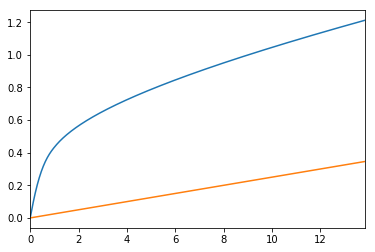

Solving the same model "the long way" took 1.95571 seconds.


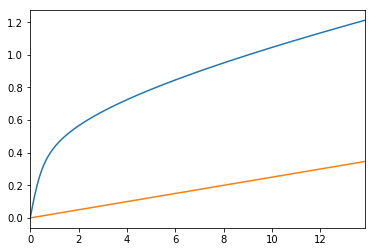

Difference between the (employed) consumption functions:


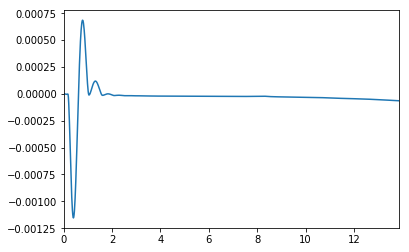

In [35]:
    ExampleAgent_sim.solve()
    
    #print('Solving a tractable consumption-savings model took ' + str(t_end-t_start) + ' seconds.')
    
    # Plot the consumption function and whatnot
    m_upper = 1.5*ExampleAgent_sim.mTarg
    conFunc_PF = lambda m: ExampleAgent_sim.h*ExampleAgent_sim.PFMPC + ExampleAgent_sim.PFMPC*m
    #plotFuncs([ExampleAgent_sim.solution[0].cFunc,ExampleAgent_sim.mSSfunc,ExampleAgent_sim.cSSfunc],0,m_upper)
    lgd = {'x':'xvals','y':'yvals'}
    plotFuncs([ExampleAgent_sim.solution[0].cFunc,ExampleAgent_sim.solution[0].cFunc_U],0,m_upper,legend_kwds= lgd)
    
    do_simulation = True # NEED TO DESCRIBE THIS
    
    # Define a dictionary to be used in case of simulation
    simulation_values = {'aLvlInitMean' : 0.0,  # Mean of log initial assets for new agents 
                         'aLvlInitStd' : 1.0,   # Stdev of log initial assets for new agents
                         'AgentCount' : 10000,  # Number of agents to simulate
                         'T_sim' : 120,         # Number of periods to simulate
                         'T_cycle' : 1}         # Number of periods in the cycle
    
    if do_simulation:
        ExampleAgent_sim(**simulation_values) # Set attributes needed for simulation
        ExampleAgent_sim.track_vars = ['mLvlNow']
        ExampleAgent_sim.makeShockHistory()
        ExampleAgent_sim.initializeSim()
        ExampleAgent_sim.simulate()
        
    
    # Now solve the same model using backward induction rather than the analytic method of TBS.
    # The TBS model is equivalent to a Markov model with two states, one of them absorbing (permanent unemployment).
    MrkvArray = np.array([[1.0-base_primitives['UnempPrb'],base_primitives['UnempPrb']],[0.0,1.0]]) # Define the two state, absorbing unemployment Markov array
    init_consumer_objects = {"CRRA":base_primitives['CRRA'],
                            "Rfree":np.array(2*[base_primitives['Rfree']]), # Interest factor (same in both states)
                            "PermGroFac":[np.array(2*[base_primitives['PermGroFac']/(1.0-base_primitives['UnempPrb'])])], # Unemployment-compensated permanent growth factor
                            "BoroCnstArt":None,   # Artificial borrowing constraint
                            "PermShkStd":[0.0],   # Permanent shock standard deviation
                            "PermShkCount":1,     # Number of shocks in discrete permanent shock distribution
                            "TranShkStd":[0.0],   # Transitory shock standard deviation
                            "TranShkCount":1,     # Number of shocks in discrete permanent shock distribution
                            "T_cycle":1,          # Number of periods in cycle
                            "UnempPrb":0.0,       # Unemployment probability (not used, as the unemployment here is *permanent*, not transitory)
                            "UnempPrbRet":0.0,    # Unemployment probability when retired (irrelevant here)
                            "T_retire":0,         # Age at retirement (turned off)
                            "IncUnemp":0.0,       # Income when unemployed (irrelevant)
                            "IncUnempRet":0.0,    # Income when unemployed and retired (irrelevant)
                            "aXtraMin":0.001,     # Minimum value of assets above minimum in grid
                            "aXtraMax":ExampleAgent_sim.mUpperBnd, # Maximum value of assets above minimum in grid
                            "aXtraCount":48,      # Number of points in assets grid
                            "aXtraExtra":[None],  # Additional points to include in assets grid
                            "aXtraNestFac":3,     # Degree of exponential nesting when constructing assets grid
                            "LivPrb":[np.array([1.0,1.0])], # Survival probability
                            "DiscFac":base_primitives['DiscFac'], # Intertemporal discount factor
                            'AgentCount':1,       # Number of agents in a simulation (irrelevant)
                            'tax_rate':0.0,       # Tax rate on labor income (irrelevant)
                            'vFuncBool':False,    # Whether to calculate the value function
                            'CubicBool':True,     # Whether to use cubic splines (False --> linear splines)
                            'MrkvArray':[MrkvArray] # State transition probabilities
                            }
    MarkovType = MarkovConsumerType(**init_consumer_objects)   # Make a basic consumer type
    employed_income_dist = [np.ones(1),np.ones(1),np.ones(1)]    # Income distribution when employed
    unemployed_income_dist = [np.ones(1),np.ones(1),np.zeros(1)] # Income distribution when permanently unemployed
    MarkovType.IncomeDstn = [[employed_income_dist,unemployed_income_dist]]  # set the income distribution in each state
    MarkovType.cycles = 0
    
    # Solve the "Markov TBS" model
    t_start = clock()
    MarkovType.solve()
    t_end = clock()
    MarkovType.unpackcFunc()
    
    print('Solving the same model "the long way" took ' + str(t_end-t_start) + ' seconds.')
    #plotFuncs([ExampleAgent_sim.solution[0].cFunc,ExampleAgent_sim.solution[0].cFunc_U],0,m_upper)
    plotFuncs(MarkovType.cFunc[0],0,m_upper)
    diffFunc = lambda m : ExampleAgent_sim.solution[0].cFunc(m) - MarkovType.cFunc[0][0](m)
    print('Difference between the (employed) consumption functions:')
    plotFuncs(diffFunc,0,m_upper)

We solve the model using HARK simulation. Specifically, we use a method of the superclass `AgentType` (the subclass, `TractableConsumerType` inherits all methods of the superclass, then can add/ modify methods to fit the subclass). The method is, unsurprisingly, named `simulate`.
<br/>
The `simulate` method iterates over the lifetime of the agent (set via the parameter `T_sim`) and, each period, uses the parameters initially given (prior to the `.simulate()` call) to compute the expected outcome of each period. Thus, we simulate the agent's life based on the inputs to determine the solution to the consumer's optimization problem (save vs. consume) at each period. We then use the values at each period to describe the function that characterizes the solution (optimal saving vs consumption). 
<br/>
<br/>
Below, we solve the consumption-saving problem via simulation.

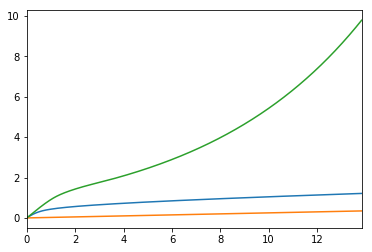

In [36]:

ExampleAgent_sim.solve()
do_simulation = True # NEED TO DESCRIBE THIS
    
    # Define a dictionary to be used in case of simulation
simulation_values = {'aLvlInitMean' : 0.0,  # Mean of log initial assets for new agents 
                         'aLvlInitStd' : 1.0,   # Stdev of log initial assets for new agents
                         'AgentCount' : 10000,  # Number of agents to simulate
                         'T_sim' : 120,         # Number of periods to simulate
                         'T_cycle' : 1}         # Number of periods in the cycle
    
if do_simulation:
    ExampleAgent_sim(**simulation_values) # Set attributes needed for simulation
    ExampleAgent_sim.track_vars = ['mLvlNow']
    ExampleAgent_sim.makeShockHistory()
    ExampleAgent_sim.initializeSim()
    ExampleAgent_sim.simulate()
    m_upper = 1.5*ExampleAgent_sim.mTarg
        
        
conFunc_PF = lambda m: ExampleAgent_sim.h*ExampleAgent_sim.PFMPC + ExampleAgent_sim.PFMPC*m
    #plotFuncs([ExampleAgent_sim.solution[0].cFunc,ExampleAgent_sim.mSSfunc,ExampleAgent_sim.cSSfunc],0,m_upper)
modprims = {'UnempPrb' : .000625,    # Probability of becoming unemployed
    'DiscFac' : 0.975,      # Intertemporal discount factor
    'Rfree' : 1.01,         # Risk-free interest factor on assets
    'PermGroFac' : 1.25,  # Permanent income growth factor (uncompensated)
    'CRRA' : 1.0} 
ex2 = TractableConsumerType(**modprims)
ex2.solve()
plotFuncs([ExampleAgent_sim.solution[0].cFunc,ExampleAgent_sim.solution[0].cFunc_U, ex2.solution[0].cFunc],0,m_upper, 
          legend_kwds = {'x':'line','y':'linez'})


We now compare our solution via simulation to the solution by backward induction, using a Markov model with two states

Solving the same model "the long way" took 2.029047 seconds.


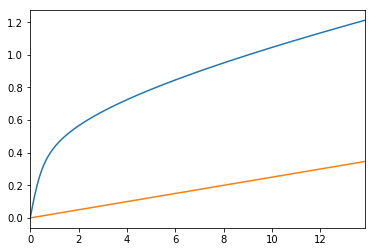

Difference between the (employed) consumption functions:


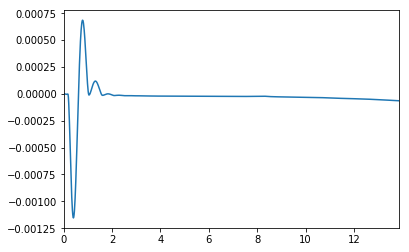

In [37]:
    # Now solve the same model using backward induction rather than the analytic method of TBS.
    # The TBS model is equivalent to a Markov model with two states, one of them absorbing (permanent unemployment).
    MrkvArray = np.array([[1.0-base_primitives['UnempPrb'],base_primitives['UnempPrb']],[0.0,1.0]]) # Define the two state, absorbing unemployment Markov array
    init_consumer_objects = {"CRRA":base_primitives['CRRA'],
                            "Rfree":np.array(2*[base_primitives['Rfree']]), # Interest factor (same in both states)
                            "PermGroFac":[np.array(2*[base_primitives['PermGroFac']/(1.0-base_primitives['UnempPrb'])])], # Unemployment-compensated permanent growth factor
                            "BoroCnstArt":None,   # Artificial borrowing constraint
                            "PermShkStd":[0.0],   # Permanent shock standard deviation
                            "PermShkCount":1,     # Number of shocks in discrete permanent shock distribution
                            "TranShkStd":[0.0],   # Transitory shock standard deviation
                            "TranShkCount":1,     # Number of shocks in discrete permanent shock distribution
                            "T_cycle":1,          # Number of periods in cycle
                            "UnempPrb":0.0,       # Unemployment probability (not used, as the unemployment here is *permanent*, not transitory)
                            "UnempPrbRet":0.0,    # Unemployment probability when retired (irrelevant here)
                            "T_retire":0,         # Age at retirement (turned off)
                            "IncUnemp":0.0,       # Income when unemployed (irrelevant)
                            "IncUnempRet":0.0,    # Income when unemployed and retired (irrelevant)
                            "aXtraMin":0.001,     # Minimum value of assets above minimum in grid
                            "aXtraMax":ExampleAgent_sim.mUpperBnd, # Maximum value of assets above minimum in grid
                            "aXtraCount":48,      # Number of points in assets grid
                            "aXtraExtra":[None],  # Additional points to include in assets grid
                            "aXtraNestFac":3,     # Degree of exponential nesting when constructing assets grid
                            "LivPrb":[np.array([1.0,1.0])], # Survival probability
                            "DiscFac":base_primitives['DiscFac'], # Intertemporal discount factor
                            'AgentCount':1,       # Number of agents in a simulation (irrelevant)
                            'tax_rate':0.0,       # Tax rate on labor income (irrelevant)
                            'vFuncBool':False,    # Whether to calculate the value function
                            'CubicBool':True,     # Whether to use cubic splines (False --> linear splines)
                            'MrkvArray':[MrkvArray] # State transition probabilities
                            }
    MarkovType = MarkovConsumerType(**init_consumer_objects)   # Make a basic consumer type
    employed_income_dist = [np.ones(1),np.ones(1),np.ones(1)]    # Income distribution when employed
    unemployed_income_dist = [np.ones(1),np.ones(1),np.zeros(1)] # Income distribution when permanently unemployed
    MarkovType.IncomeDstn = [[employed_income_dist,unemployed_income_dist]]  # set the income distribution in each state
    MarkovType.cycles = 0
    
    # Solve the "Markov TBS" model
    t_start = clock()
    MarkovType.solve()
    t_end = clock()
    MarkovType.unpackcFunc()
    
    print('Solving the same model "the long way" took ' + str(t_end-t_start) + ' seconds.')
    #plotFuncs([ExampleAgent_sim.solution[0].cFunc,ExampleAgent_sim.solution[0].cFunc_U],0,m_upper)
    plotFuncs(MarkovType.cFunc[0],0,m_upper)
    diffFunc = lambda m : ExampleAgent_sim.solution[0].cFunc(m) - MarkovType.cFunc[0][0](m)
    print('Difference between the (employed) consumption functions:')
    plotFuncs(diffFunc,0,m_upper)

In [38]:
plotFuncs(a.solution[0].cFunc,0,10)

NameError: name 'a' is not defined

In [ ]:
plotFuncs(a.mSSfunc,0,10)

In [ ]:
vars(a)

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0,10,1000,True)
y = a.solution[0].cFunc(x)
plt.plot(x, y)
plt.plot(x, a.mSSfunc(x))
plt.axis('tight')
plt.show()

In [ ]:
class test():
    def __init__(self,a=3,b=4):
        self.a = a
        self.c = b
    def run(self):
        self.a = self.a + self.c

In [ ]:
a = test()

In [ ]:
b=test(1,2)

In [ ]:
a.run()
b.run()

In [ ]:
a.a

In [ ]:
b.a